In [189]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

# load python modules
%load_ext autoreload
%autoreload 2
SRC_PATH = '/Users/tabea/Documents/UrbanMobility/src'
import sys
sys.path.append(SRC_PATH)
from models_ml_dl import tree_models as tree_models
from visualization import model_evaluation as eval
from visualization import model_interpretation_vis as model_interpret


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Interpretability: Random Forest

### 1.1 Data & Model Loading: Tree-based Models

In [2]:
journey_daily_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2016.csv', parse_dates=['start_date'], index_col=0)
journey_daily_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2017.csv', parse_dates=['start_date'], index_col=0)
journey_daily_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2018.csv', parse_dates=['start_date'], index_col=0)
journey_daily_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_daily_train = pd.concat([journey_daily_16, journey_daily_17, journey_daily_18])
journey_daily_test = journey_daily_19.copy()

# train test split
x_daily_train, y_daily_train, x_daily_test, y_daily_test = tree_models.train_test_split(journey_daily_train, journey_daily_test)

In [3]:
#load model
rf_daily = joblib.load('../models/random_forest_daily.pkl')
gb_daily = joblib.load('../models/random_forest_daily.pkl')

#pred
feature_cols_daily = x_daily_train.columns.drop(['start_date', 'hour']) 
y_pred_rf = rf_daily.predict(x_daily_test[feature_cols_daily])
y_pred_gb = gb_daily.predict(x_daily_test[feature_cols_daily])

### 1.2 Accumulated Local Effects Plot: Random Forest

In [ ]:
ale_exp = model_interpret.ale_explainer(rf_daily, feature_cols_daily, x_daily_test[feature_cols_daily])

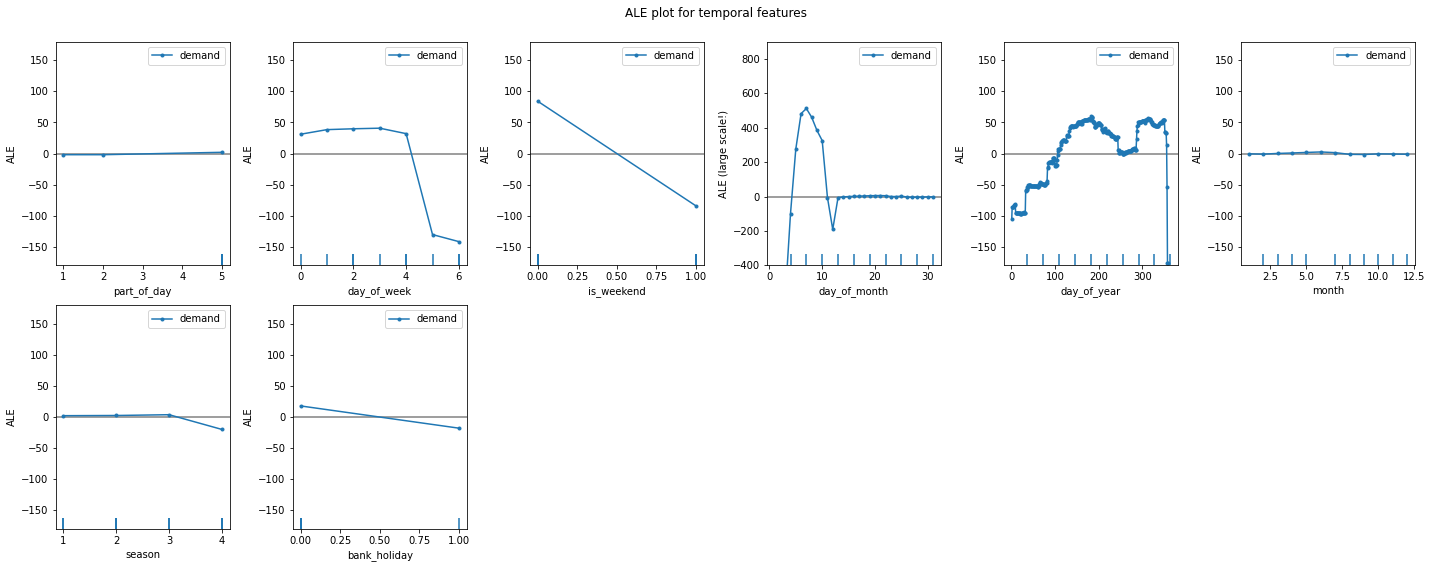

In [117]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('day_of_month')]

temporal_features = ['part_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'day_of_year', 'month', 'season', 'bank_holiday']
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, temporal_features, 8, 0.92, 'temporal features', large_scale_index)

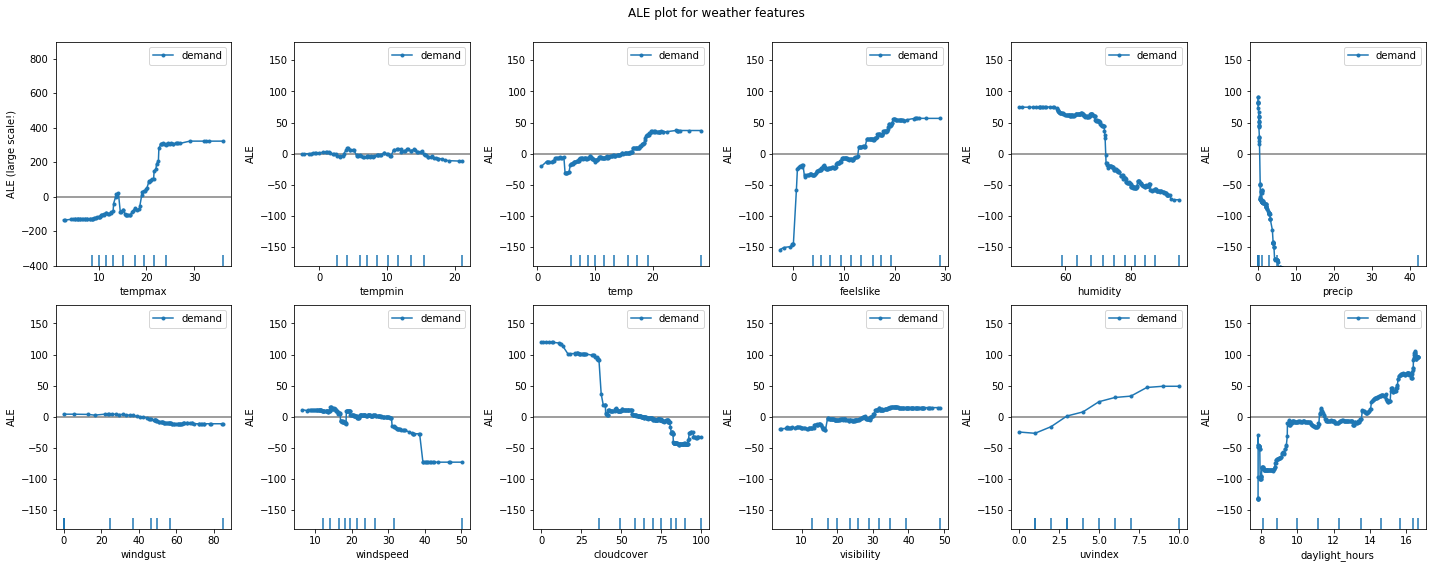

In [116]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('tempmax')]

weather_features = ['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours']
interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, weather_features, 8, 0.92, 'weather features', large_scale_index)

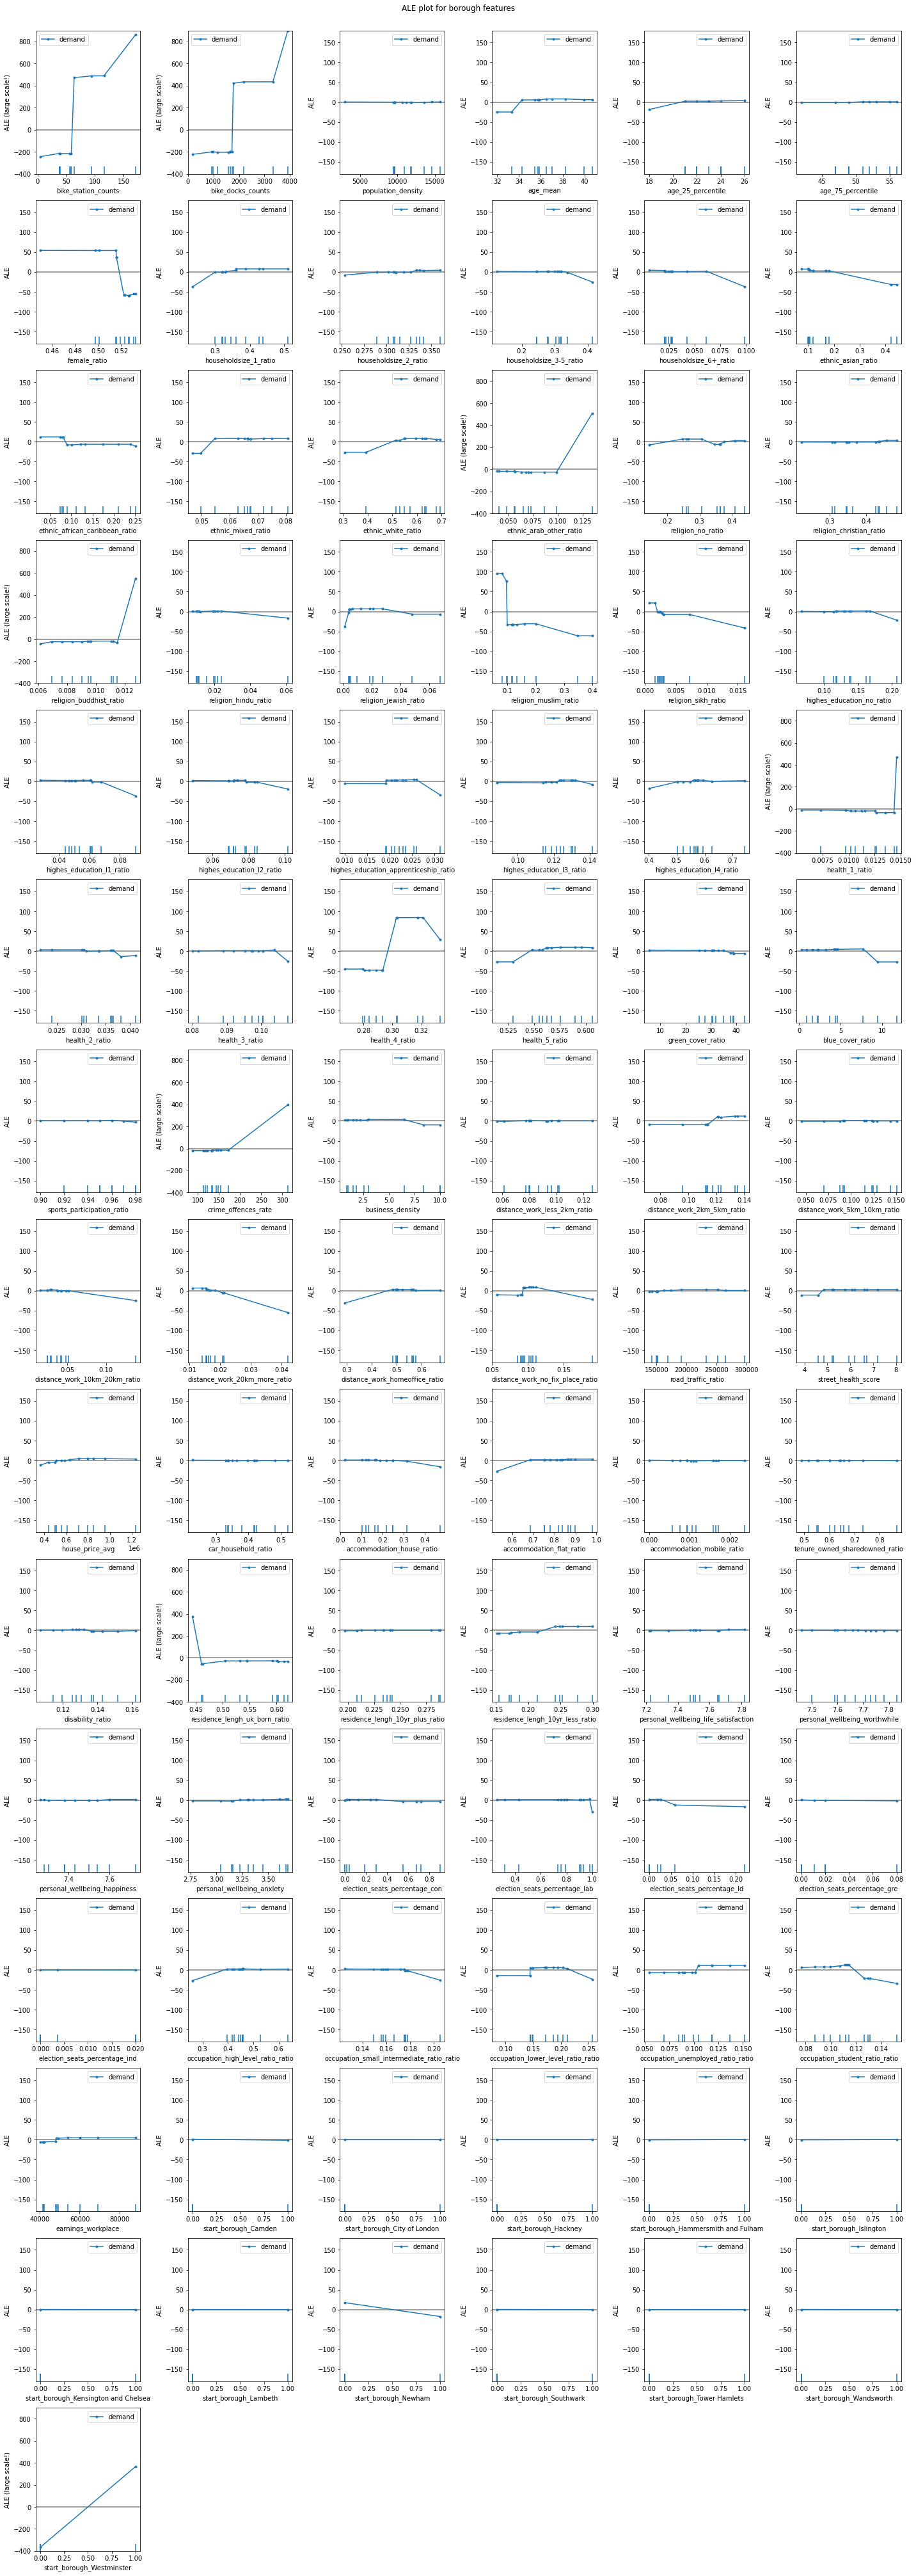

In [115]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('bike_station_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('bike_docks_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('ethnic_arab_other_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('religion_buddhist_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('health_1_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('start_borough_Westminster'),
                     x_daily_test[feature_cols_daily].columns.get_loc('residence_lengh_uk_born_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('crime_offences_rate')
                     ]

borough_features = x_daily_test[feature_cols_daily].columns[~x_daily_test[feature_cols_daily].columns.isin(temporal_features) & ~x_daily_test[feature_cols_daily].columns.isin(weather_features)]
interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp, borough_features, 57, 0.97, 'borough features', large_scale_index)

### 1.3 Permutation Feature Importance

In [122]:
perm_feature_importances = model_interpret.permutation_tree(rf_daily, x_daily_test[feature_cols_daily], y_daily_test)

# Display the feature importances
for name, importance in perm_feature_importances:
    print(f"Feature: {name}, Score: {importance}")

Feature: day_of_month, Score: 0.16398126037054697
Feature: bike_station_counts, Score: 0.10349984373950716
Feature: bike_docks_counts, Score: 0.09240961366631692
Feature: tempmax, Score: 0.07407839832765557
Feature: religion_buddhist_ratio, Score: 0.018262853935556156
Feature: start_borough_Westminster, Score: 0.01700651756681155
Feature: precip, Score: 0.015972936447325847
Feature: day_of_week, Score: 0.014260590435138498
Feature: ethnic_arab_other_ratio, Score: 0.014239738735886642
Feature: is_weekend, Score: 0.013811836658339783
Feature: health_1_ratio, Score: 0.012731013376326117
Feature: residence_lengh_uk_born_ratio, Score: 0.008259043878537865
Feature: crime_offences_rate, Score: 0.007596739900118399
Feature: day_of_year, Score: 0.005360070768957592
Feature: humidity, Score: 0.0038347591307698937
Feature: religion_sikh_ratio, Score: 0.003481009696540882
Feature: religion_muslim_ratio, Score: 0.002509373150817873
Feature: health_4_ratio, Score: 0.0021752470738508833
Feature: fema

### 1.4 Shapley Additive Explanations (SHAP)

In [4]:
filename_expl = '../models/shap_explainer_rf.sav'
filename_val = '../models/shap_values_rf.sav'

shap_values = model_interpret.create_shap(rf_daily, x_daily_test[feature_cols_daily], filename_expl, filename_val)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


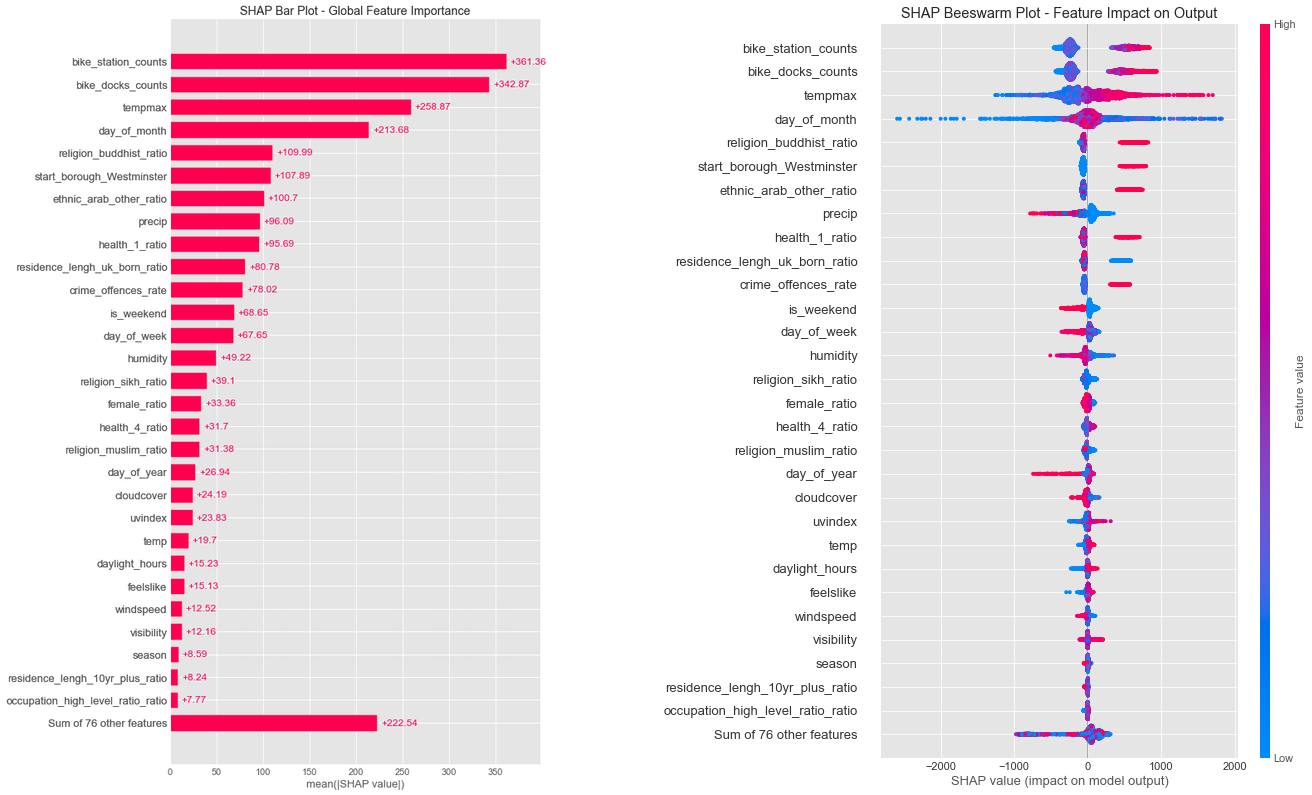

<Figure size 576x972 with 0 Axes>

In [190]:
filename_bar_plot = '../reports/figures/shap_global_plots/global_bar_plot.png'
filename_beeswarm_plot = '../reports/figures/shap_global_plots/global_beeswarm_plot.png'
filename_final = '../reports/figures/shap_global_plots/combined_global_shap_plots.png'

model_interpret.plot_shap_bar_and_beeswarm(shap_values, filename_bar_plot, filename_beeswarm_plot, filename_final)

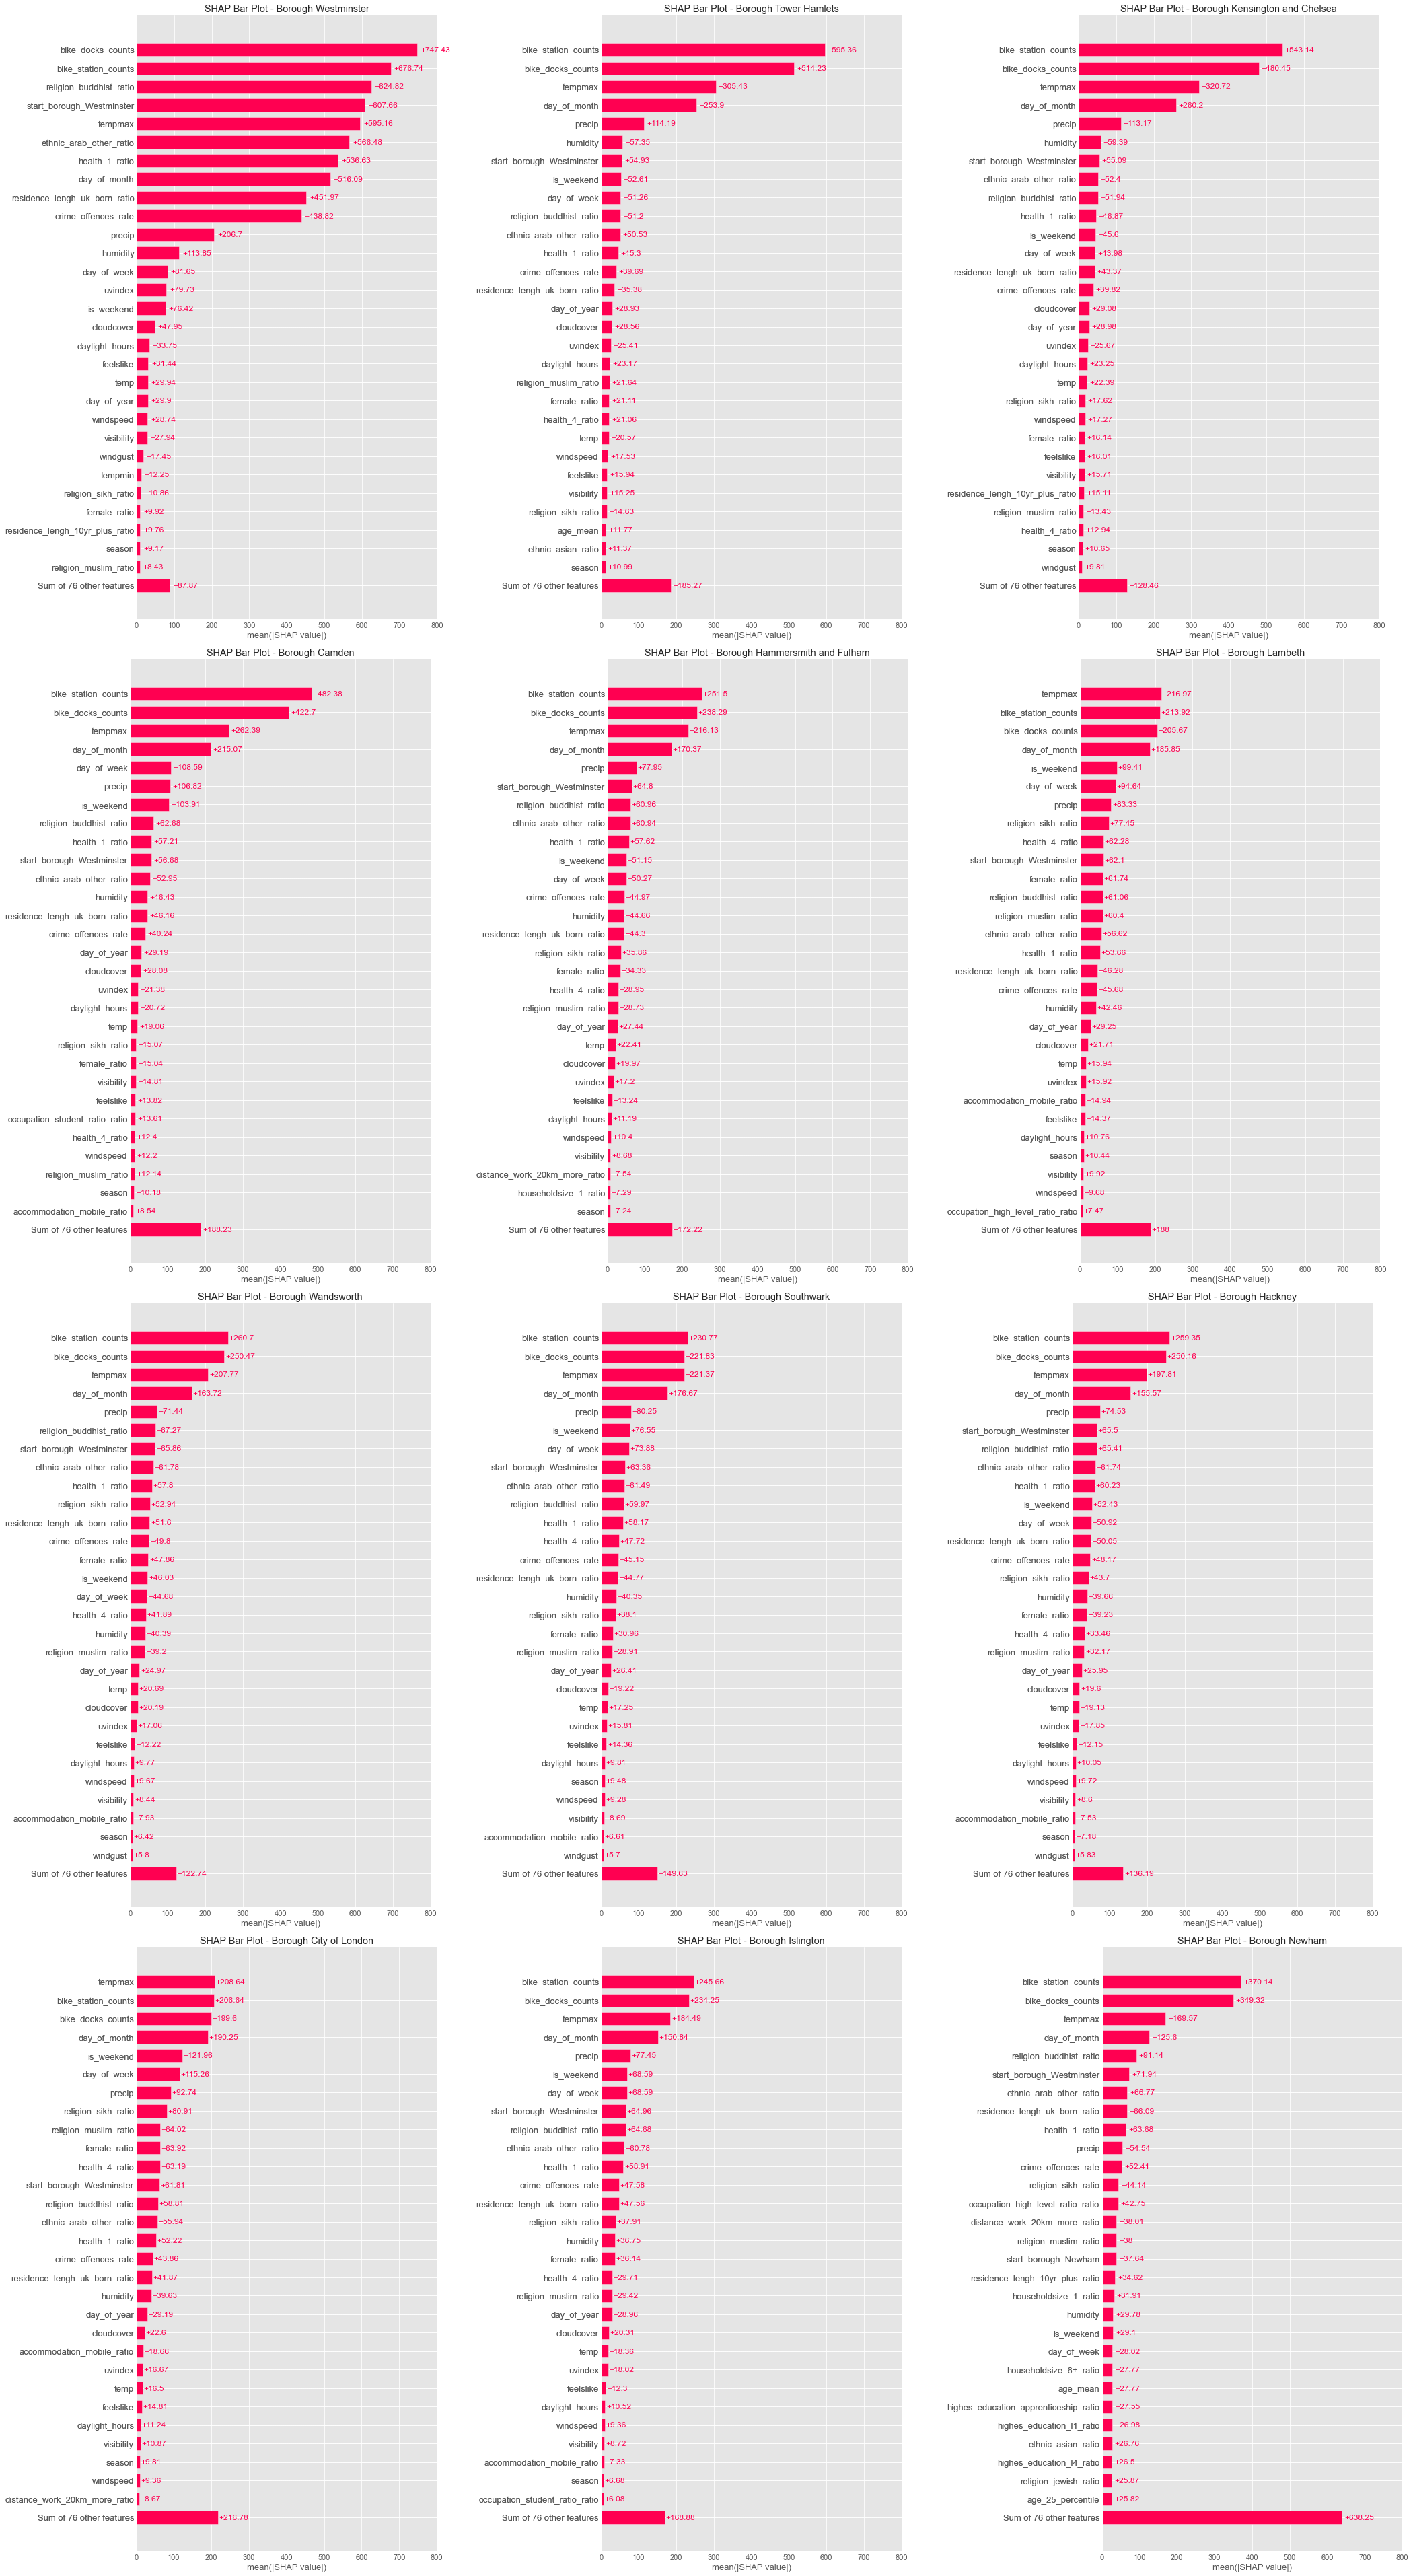

<Figure size 576x1188 with 0 Axes>

In [191]:
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 
            'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

global_min = 0
global_max = 800

filename_bar_plots = '../reports/figures/shap_bar_plots/'
filename_final_boroughs = '../reports/figures/shap_bar_plots/combined_borough_shap_plots.png'

model_interpret.plot_boroughs_bar(shap_values, x_daily_test, boroughs, global_min, global_max, filename_bar_plots, filename_final_boroughs)

# 2. Interpretability: Gradient Boosting

# 3. Interpretability: Deep Learning

### Data & Model Loading: Deep Learning